# Multi-Controlled U Gates

In [1]:
# First need to import qiskit, numpy, matplotlib, and pylatexenc, along with and some important functions from qiskit
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import pylatexenc
import sympy as sp

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import RXGate, RYGate, RZGate
from qiskit.quantum_info import Statevector, Operator

In [2]:
# Check version
qiskit.__version__

'2.0.0'

### Constructing Controlled U Gate (n=1)

Any 1-qubit gate $U\in U(2)$ can be written as
$$U = e^{i\gamma}R_z(\phi)R_y(\theta)R_z(\lambda)$$
for some $\theta,\phi,\lambda, \gamma \in [0,2\pi)$. Moreover, setting
$$A := R_z(\phi)R_y\left(\frac{\theta}{2}\right),$$
$$B := R_y\left(-\frac{\theta}{2}\right)R_z\left(-\frac{\lambda+\phi}{2}\right),$$
and 
$$C := R_z\left(\frac{\lambda-\phi}{2}\right),$$
we have that 
$$ABC = I$$
and 
$$U = e^{i\theta}AXBXC$$
(Nielson & Chuang Corollary 4.2).

Therefore, we can create an arbitrary controlled-U gate using just arbitrary 1-qubit gates and CX gates by creating the following circuit:

Given an arbitrary 1-qubit gate $U\in U(2)$, we can obtain the angles $\alpha,\beta,\gamma,\theta$ such that $U = e^{i\theta}R_z(\alpha)R_y(\beta)R_z(\gamma)$ by invoking the OneQubitEulerDecomposer class. For example,

In [3]:
Z_gate = np.array([[1, 0], [0, -1]])

angle_decomp = qiskit.synthesis.OneQubitEulerDecomposer(basis = "ZYZ")

angle_decomp.angles_and_phase(Z_gate)  # note that the list is of the form [theta, phi, lambda, gamma]

[0.0, 0.0, 3.141592653589793, 1.5707963267948966]

Indeed, you can check that this gives us the $Z$ gate when we plug in these angle values into $e^{i\theta}R_z(\alpha)R_y(\beta)R_z(\gamma)$. 

To construct an arbitrary controlled-U gate using only 1-qubit gates and $CX$ gates, we construct a circuit that does the following:
1. Applies C gate to second qubit
2. Applies CX gate with first qubit as control
3. Applies B gate to second qubit
4. Applies CX gate with first qubit as control
5. Applies A gate to second qubit

Therefore, if the first qubit is 0, then we have $ABC|y> = |y>$; on the other hand, if the first qubit is $1$, then we have $AXBXC|y> = U|y>$. 

If, for example, we wanted to make a control-Z gate, we would would construct the following circuit:

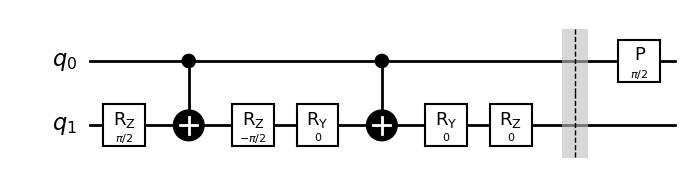

In [4]:
# Initialize parameters; applying OneQubitEulerDecomposer for Z gate gives angles 0, 0, pi, pi/2
Theta, Phi, Lambda, Gamma = 0, 0, np.pi, np.pi/2

# Set up circuit
qr = QuantumRegister(size = 2, name = "q")
qc = QuantumCircuit(qr)

# Note that 1-qubit gate operations are listed in reverse order of their product since matrix multiplication is function composition
qc.rz((Lambda-Phi)/2, qr[1])  # Z gate
qc.cx(qr[0], qr[1])  # CX gate
qc.rz(-(Lambda+Phi)/2, qr[1])  # second factor of B
qc.ry(-Theta/2, qr[1])  # first factor of B
qc.cx(qr[0], qr[1])  # CX gate
qc.ry(Theta/2, qr[1])  # second factor of A
qc.rz(Phi, qr[1])  # first factor of A
qc.barrier()
qc.p(Gamma, qr[0]) # apply global phase

qc.draw(output="mpl", style="bw")

In [5]:
print(np.round(Operator(qc).data))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


You can check that this is indeed the matrix for the CZ gate

This circuit framework seems to work, so let's define a function that takes in any 1-qubit gate $U$ and outputs a circuit for the $CU$ gate. 

In [6]:
def CU_circuit(U_gate):
    """
    Creates the 2-qubit circuit for an arbitrary CU gate. 
    
    Parameters:
    - U_gate: any 2x2 unitary matrix, defined as a numpy array

    Returns:
    - The 2-qubit circuit corresponding to the controlled-U_gate gate
    """
    
    angle_decomp = qiskit.synthesis.OneQubitEulerDecomposer(basis = "ZYZ")  # find angles for R_zR_yR_z decomposition
    angles = angle_decomp.angles_and_phase(U_gate)  # create list of angles
    
    Theta, Phi, Lambda, Gamma = angles[0], angles[1], angles[2], angles[3]

    # Set up circuit
    qr = QuantumRegister(size = 2, name = "q")
    qc = QuantumCircuit(qr)

    qc.rz((Lambda-Phi)/2, qr[1])  # Z gate
    qc.cx(qr[0], qr[1])  # CX gate
    qc.rz(-(Lambda+Phi)/2, qr[1])  # second factor of B
    qc.ry(-Theta/2, qr[1])  # first factor of B
    qc.cx(qr[0], qr[1])  # CX gate
    qc.ry(Theta/2, qr[1])  # second factor of A
    qc.rz(Phi, qr[1])  # first factor of A
    qc.barrier()
    qc.p(Gamma, qr[0]) # apply global phase
    
    return qc

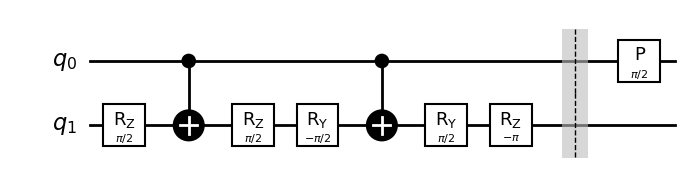

In [7]:
# Observe that if we plug in the X gate into the CU_circuit function and draw it out, we get circuit corresponding to the CX gate
CU_circuit(np.array([[0, 1], [1, 0]])).draw(output="mpl", style="bw")

Indeed, you can check that the matrix corresponding to the above circuit is the $CX$ gate:

In [8]:
print(np.round(Operator(CU_circuit(np.array([[0, 1], [1, 0]]))).data, 3))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j  1.-0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]]


### Constructing the Toffoli Gate

Having constructed an arbitrary controlled $U$ gate out of just 1-qubit gates and $CX$ gates, we can use this to construct a controlled-controlled $U$ gate. In particular, to get an arbitrary $CCU$ gate, we construct a 3-qubit circuit which does the following:

1. Applies $CV$ gate with $2^{nd}$ qubit as control and $3^{rd}$ qubit as target
2. Applies $CX$ gate with $1^{st}$ qubit as control and $2^{nd}$ qubit as target
3. Applies $CV^{\dagger}$ gate with $2^{nd}$ qubit as control and $3^{rd}$ qubit as target
4. Applies $CX$ gate with $1^{st}$ qubit as control and $2^{nd}$ qubit as target
5. Applies $CV$ gate with $2^{nd}$ qubit as control and $3^{rd}$ qubit as target

such that $V^2 = U$. You can check that this implements the $CCU$ gate. 

When $V = \frac{1-i}{2}(I+iX)$, $V^2 = X$, and so in particular we will implement the above circuit with said $V$ to obtain the Toffoli gate (page 182, Nielson & Chuang). First, we need to decompose $V$ into a product of rotations as before.

In [9]:
# Find the angles alpha, beta, gamma, theta such that V = e^{i*theta}R_z(alpha)R_y(beta)R_z(gamma)
V = (1-1j)/2*np.array([[1, 1j], [1j, 1]])

angle_decomp = qiskit.synthesis.OneQubitEulerDecomposer(basis = "ZYZ")

angle_decomp.angles_and_phase(V)

[1.5707963267948966,
 1.5707963267948966,
 -1.5707963267948966,
 -0.7853981633974483]

Therefore, $V = e^{-i\frac{\pi}{4}}R_z\left(\frac{\pi}{2}\right)R_y\left(\frac{\pi}{2}\right)R_z\left(-\frac{\pi}{2}\right)$. We can obtain both $V$ and $V^{\dagger} = V^{-1}$ by defining the following function:

In [10]:
def custom_gate(alpha: float, beta: float, gamma: float, theta: float):
    """
    Creates a custom 1-qubit gate which is the product of rotation matrices:
    e^{i*theta}*R_z(alpha)*R_y(beta)*R_z(gamma)

    Parameters:
    - alpha: rotation angle around Z-axis (first Rz)
    - beta: rotation angle around Y-axis (Ry)
    - gamma: rotation angle around Z-axis (second Rz)
    - theta: global phase angle

    Returns:
    - A gate object representing the combined rotations.
    """
    
    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)
    qc.rz(gamma, 0)
    qc.ry(beta, 0)
    qc.rz(alpha, 0)
    qc.global_phase = -theta
    
    return qc.to_gate()

In [11]:
# V gate circuit
qc = QuantumCircuit(1)
V_gate = custom_gate(np.pi/2, np.pi/2, -np.pi/2, np.pi/4)
qc.append(V_gate, [0])

# V gate matrix
V = Operator(qc).data
V

array([[0.5-0.5j, 0.5+0.5j],
       [0.5+0.5j, 0.5-0.5j]])

In [12]:
# V^{\dagger} gate circuit
qc = QuantumCircuit(1)
V_gate = custom_gate(np.pi/2, np.pi/2, -np.pi/2, np.pi/4)
Vdag_gate = V_gate.inverse()
qc.append(Vdag_gate, [0])

Vdag = Operator(qc).data
Vdag

array([[0.5+0.5j, 0.5-0.5j],
       [0.5-0.5j, 0.5+0.5j]])

Note that by applying the CU_circuit function to V and Vdag, we get the circuits corresponding to the $CV$ and $CV^{\dagger}$ respectively. 

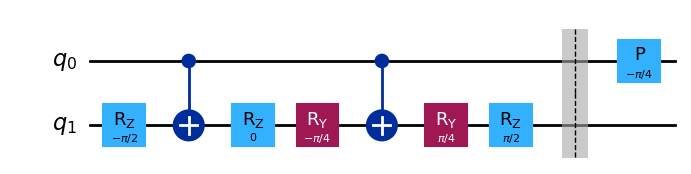

In [13]:
CV = CU_circuit(V)
CV.draw('mpl')

In [14]:
# Check that the corresponding matrix to this circuit is in fact CV:
print(np.round(Operator(CV).data, 3))

[[ 1. +0.j   0. +0.j   0. -0.j   0. +0.j ]
 [ 0. +0.j   0.5-0.5j  0. +0.j   0.5+0.5j]
 [-0. -0.j   0. +0.j   1. -0.j   0. +0.j ]
 [ 0. +0.j   0.5+0.5j  0. +0.j   0.5-0.5j]]


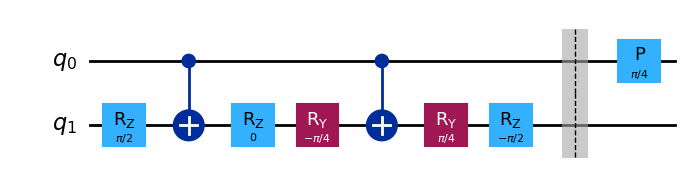

In [15]:
CVdag = CU_circuit(Vdag)
CVdag.draw('mpl')

In [16]:
# Check that the corresponding matrix to this circuit is in fact CV^{dagger}
print(np.round(Operator(CVdag).data, 3))

[[ 1. +0.j   0. +0.j  -0. +0.j   0. +0.j ]
 [ 0. +0.j   0.5+0.5j  0. +0.j   0.5-0.5j]
 [ 0. +0.j   0. +0.j   1. +0.j   0. +0.j ]
 [ 0. +0.j   0.5-0.5j  0. +0.j   0.5+0.5j]]


Thus, we may now construct the Toffoli gate with the following circuit:

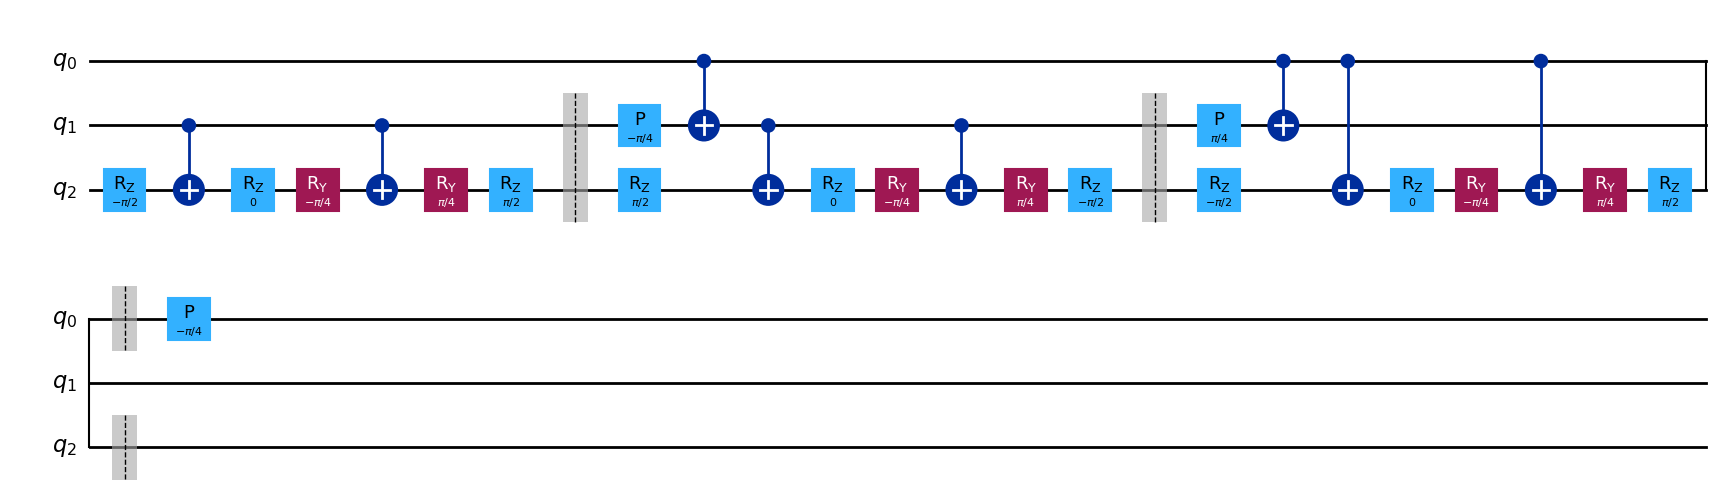

In [17]:
tc = QuantumCircuit(3)

tc.compose(CV, [1, 2], inplace=True)
tc.cx([0], [1])
tc.compose(CVdag, [1, 2], inplace=True)
tc.cx([0], [1])
tc.compose(CV, [0,2], inplace=True)

tc.draw('mpl')

In [18]:
print(np.round(Operator(tc).data, 3))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j]
 [-0.-0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -0.-0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j]]


As you can see, the matrix corresponding to the above circuit is the Toffoli gate. 

### Controlled-Controlled U Gate

We may now use the Toffoli gate and the CU_circuit function to construct an arbitrary controlled-controlled $U$ gate. If, in addition, we add an ancillary qubit, then we can obtain a controlled-controlled $U$ gate from the simple circuit:

1. Apply Toffoli gate to first, second, and ancillary qubit
2. Apply controlled $U$ gate to ancillary qubit and third qubit
3. Apply Toffoli gate to first, second, and ancillary qubit

This triggers the controlled U gate only when both the first and second qubit are equal to 1, otherwise nothing happens (which is exactly what the controlled-controlled U gate does). 

For example, we can construct the controlled-controlled $Y$ gate from the following circuit: 

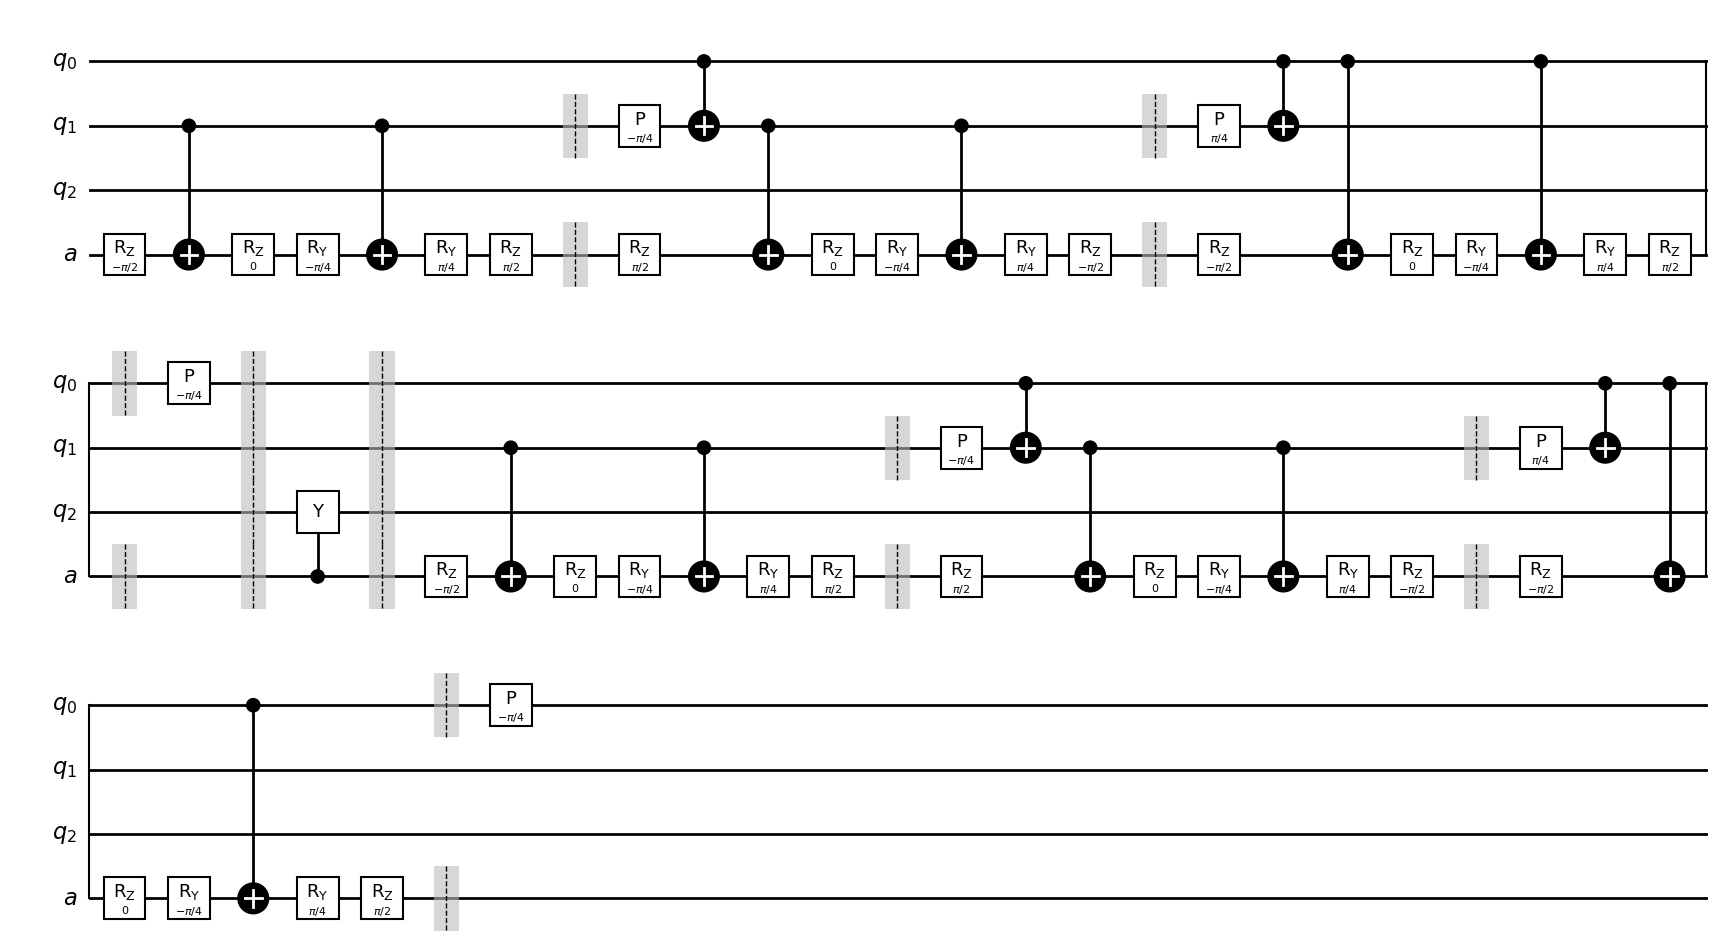

In [19]:
qr = QuantumRegister(3, "q")
ar = AncillaRegister(1, "a")

qc = QuantumCircuit(qr, ar)

qc.compose(tc, [0, 1, 3], inplace=True)
qc.barrier()
qc.cy(ar[0], qr[2])
qc.barrier()
qc.compose(tc, [0, 1, 3], inplace=True)

qc.draw(output="mpl", style="bw")

To obtain the 8x8 matrix corresponding to this circuit with the ancillary qubit traced out, we will need to run the following code:

In [20]:
# Get the full 16x16 unitary matrix
U_full = Operator(qc).data

# U_full is 16x16, reshape to [2,2,2,2] x [2,2,2,2]
U_full_tensor = U_full.reshape([2]*8)

# Fix ancilla qubit (qubit 3) to |0⟩ before and after: index 1 and 5
U_reduced = U_full_tensor[0, :, :, :, 0, :, :, :]  # Fix ancilla input and output to 0
U_reduced = U_reduced.reshape((8, 8))  # Now it's an 8x8 matrix

print("Effective 8x8 unitary matrix (ancilla in |0>):")
print(np.round(U_reduced, 3))

Effective 8x8 unitary matrix (ancilla in |0>):
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j  0.+0.j -0.-1.j]
 [-0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+1.j  0.+0.j  0.+0.j  0.+0.j -0.-0.j]]


As you can see, after tracing out the ancillary qubit, we obtain the matrix for the $CCY$ gate. 

Let's generalize this to a function that takes an arbitrary 1-qubit gate $U$ and outputs the circuit corresponding to the $CCU$ gate. 

In [21]:
def CCU_circuit(U_gate):
    """
    Creates the 4-qubit circuit (consisting of 3 qubits and 1 ancillary qubit) for an arbitrary CCU gate. 
    
    Parameters:
    - U_gate: any 2x2 unitary matrix, defined as a numpy array

    Returns:
    - The 4-qubit circuit corresponding to the controlled-controlled U_gate gate
    """
    cuc = CU_circuit(U_gate)  # use CU_circuit function to create circuit for CU gate
    
    qr = QuantumRegister(3, "q")
    ar = AncillaRegister(1, "a")

    qc = QuantumCircuit(qr, ar)

    qc.compose(tc, [0, 1, 3], inplace=True)
    qc.barrier()
    qc.compose(cuc, [3, 2], inplace=True)
    qc.barrier()
    qc.compose(tc, [0, 1, 3], inplace=True)
    
    return qc

Let's plug in the $Z$ gate into CCU_circuit to see that we get the circuit for the $CCZ$ gate. 

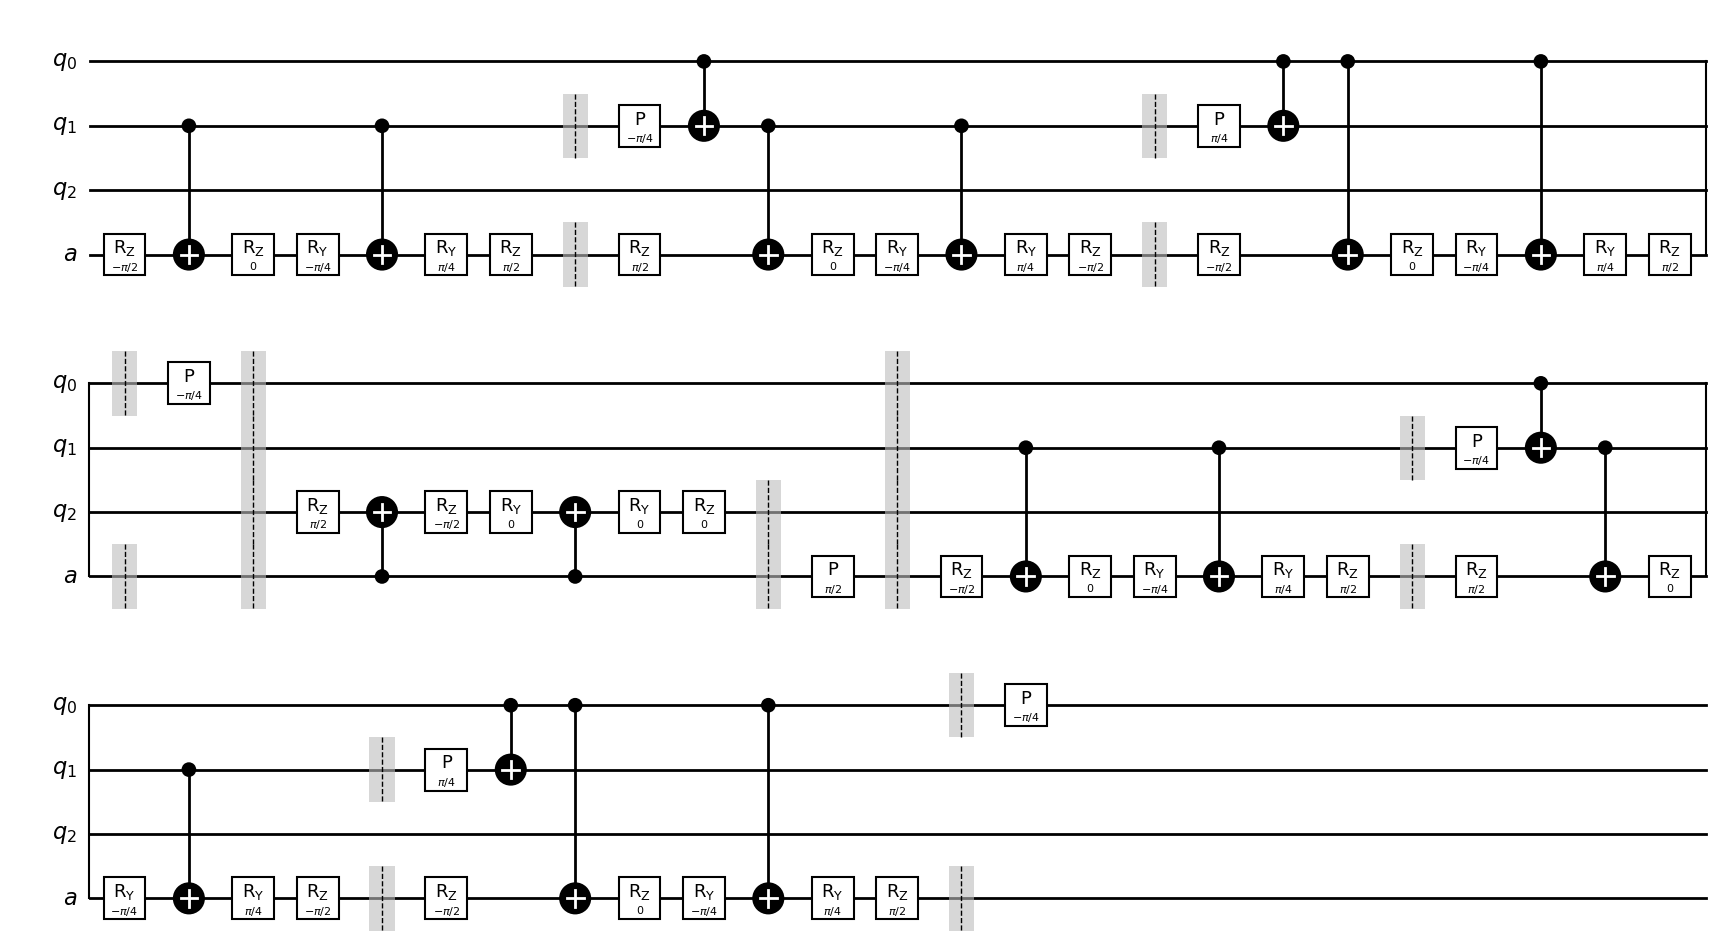

In [22]:
CCU_circuit(np.array([[1, 0], [0, -1]])).draw(output="mpl", style="bw")

This looks right... let's check that we can indeed obtain from this function the matrix corresponding to the CCZ gate.

In [23]:
# Get the full 16x16 unitary matrix
U_full = Operator(CCU_circuit(np.array([[1, 0], [0, -1]]))).data

# U_full is 16x16, reshape to [2,2,2,2] x [2,2,2,2]
U_full_tensor = U_full.reshape([2]*8)

# Fix ancilla qubit (qubit 3) to |0⟩ before and after: index 1 and 5
U_reduced = U_full_tensor[0, :, :, :, 0, :, :, :]  # Fix ancilla input and output to 0
U_reduced = U_reduced.reshape((8, 8))  # Now it's an 8x8 matrix

print("Matrix of CCZ gate after tracing out ancilla: ")
print(np.round(U_reduced, 3))

Matrix of CCZ gate after tracing out ancilla: 
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


Nice!

## Combining It All: Constructing a Multi-controlled U Gate

Given an arbitrary $CU$ gate (which we built from scratch with the CU_circuit function) and Toffoli gates (which we also built from scratch, utilizing the CU_circuit function), we can construct for an arbitrary $C^nU$ gate, where $n$ is any positive integer greater than or equal to 1 and $U$ is any 1-qubit gate. The function will be similar to function of the CCU_circuit function given in the previous section, however we will need more qubits and ancillas. 

In particular, to construct the circuit for the $C^nU$ gate, we will need a total of $2n$ qubits: $n$ qubits being the control, $1$ qubit being the target, and $n-1$ ancillary qubits. The circuit for the $C^nU$ gate is then be given by doing the following:

1. For $i=1,...,n-1$, apply Toffoli gate with $i^{th}$ and $i+1^{th}$ qubits as the control and the $i^{th}$ ancillary qubit as the target
2. Apply CU gate to the with the $(n-1)^{th}$ ancillary qubit as the control and the $(n+1)^{th}$ qubit as the target. 
3. For $i=1,...,n-1$ apply Toffoli gate with $(n-i+1)^{th}$ and $(n-i)^{th}$ qubits as the control and the $(n-i)^{th}$ ancilary qubit as the target

In [24]:
def nCU_circuit(U_gate, N):
    """
    Creates the 2*N-qubit circuit (consisting of n+1 qubits and n-1 ancillary qubits) for an arbitrary C^{N}U gate. 
    
    Parameters:
    - U_gate: any 2x2 unitary matrix, defined as a numpy array
    - N: positive integer N

    Returns:
    - The 2*N-qubit circuit corresponding to the N-controlled-U_gate gate
    """
    if not isinstance(N, int):
        raise TypeError("Input must be an integer.")  # Ensures n is an integer
    elif N <= 0:
        raise ValueError("Input must be a positive integer.")  # Ensures n is nonnegative
    elif N == 1:
        return CU_circuit(U_gate)  # In case n=1, just return CU_circuit(U_gate)
    else:
        cuc = CU_circuit(U_gate)  # otherwise, use CU_circuit function to create circuit for CU gate, and then
                                  # we build the following large circuit for corresponding to the C^nU gate
                    
        qr = QuantumRegister(N+1, "q")
        ar = AncillaRegister(N-1, "a")

        qc = QuantumCircuit(qr, ar)
    
        for i in range(N-1):
            qc.compose(tc, [i, i+1, N+i+1], inplace=True)
        qc.barrier()    
        qc.compose(cuc, [2*N-1, N], inplace=True)
        qc.barrier()
        for i in range(N-1):
            qc.compose(tc, [N-i-2, N-i-1, 2*N-i-1], inplace=True)
        
        return qc

To test this function, let's input the $Z$ gate and $N=2$, and see what circuit we get...

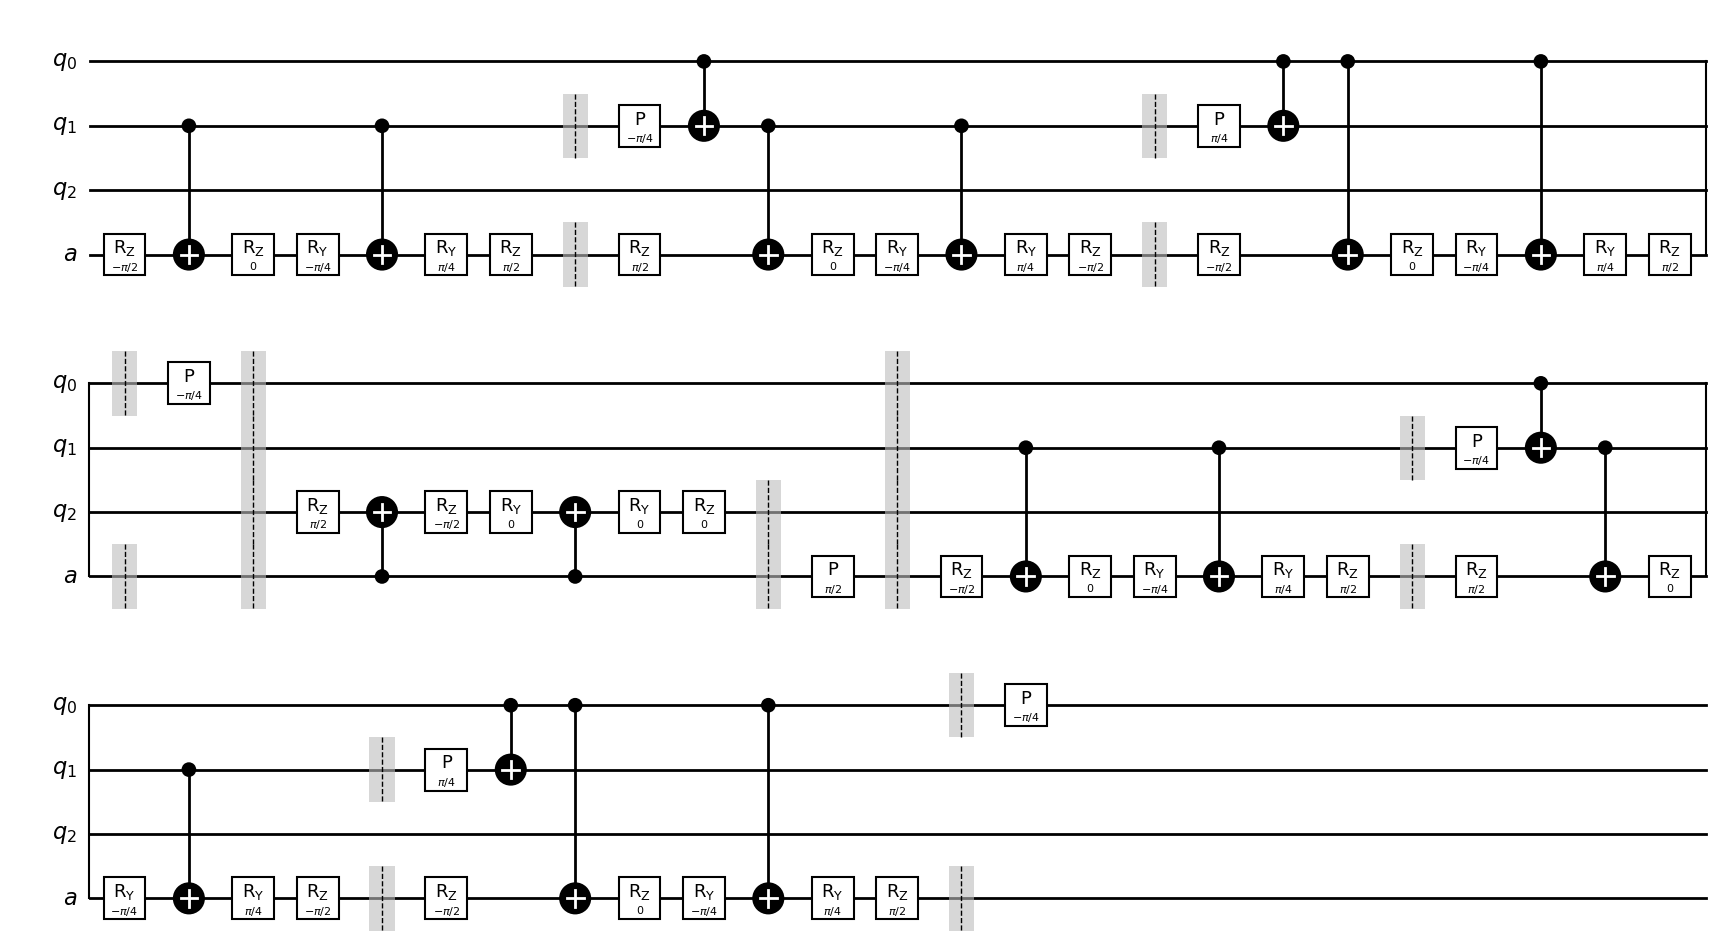

In [25]:
nCU_circuit(np.array([[1, 0], [0, -1]]), 2).draw(output="mpl", style="bw")

As you can see, this is the same circuit we got before for the $CCZ$ gate, so it appears our multi-controlled $U$ gate function works. 

### Complexity Analysis of nCU_circuit

To recap, we first constructed the CU_circuit function, which took in an arbitrary 1-qubit gate and returned an the circuit for the $CU$ gate. Then, we constructed the circuit for the Toffoli gate using the CU_circuit function and 2 CX gates. Then lastly, we constructed the nCU_circuit function, which took in an arbitrary 1-qubit gate and a positive integer, and then returned the circuit for the $C^{n}U$ gate. 

1. CU_circuit(U_gate) function required 8 universal gates
2. Toffoli circuit required:
    - 2 CU_circuit(V) gates -> 16 universal gates
    - 1 CU_circuit(Vdag) gate -> 8 universal gates
    - 2 CX gates -> 2 universal gates

   Total universal gates: 26
3. nCU_circuit(U_gate, N) function required:
    - 2*(N-1) Toffoli gates -> 2*(N-1)*26
    - CU_circuit(U) -> 8 gates
   Total universal gates: 52*(N-1)+8 = 52*N-44 universal gates

Therefore, nCU_circuit(-,N) = O(N) in terms of universal gates required. 

Note also that nCU_circuit(-,N) = O(N) in terms of the number of qubits required (since as shown above, exactly 2N qubits will be required to construct the circuit for $C^n(U)$). 